# BM3D

Python implementation of ["An Analysis and Implementation of the BM3D Image Denoising Method" by Marc Lebrun](https://www.ipol.im/pub/art/2012/l-bm3d/?utm_source=doi).

## Modules

In [28]:
import numpy as np
from skimage import io as skio
import heapq
import pywt
import math
from scipy.linalg import hadamard
import cv2

# local
import matplotlib.pyplot as plt

## Parameters

In [29]:
# 1st step
kHard = 8 #patch size
nHard = 39 #search window size --! era pra ser 39 mas nao entendi como centralizar P
NHard = 16 #max number of similar patches kept 
pHard = 3

sigma = 30
tauHard = 5000 if sigma > 40 else 2500

lambdaHard2d = 0 #hard thresholding for grouping --! ??? where
lambdaHard3d = 2.7

## Initialization

In [30]:
im = skio.imread('./lena.tif') # original image

In [31]:
def noise(im,br):
    """ Cette fonction ajoute un bruit blanc gaussier d'ecart type br
       a l'image im et renvoie le resultat"""
    imt=np.float32(im.copy())
    sh=imt.shape
    bruit=br*np.random.randn(*sh)
    imt=imt+bruit
    return imt

In [32]:
imbr = noise(im, sigma) # create noisy image

In [33]:
%%time
basic_estimate = bm3d_1st_step(imbr, sigma, kHard, nHard, lambdaHard2d, lambdaHard3d, tauHard, NHard)

NameError: name 'get_search_window' is not defined

## The First Denoising Step


### Grouping

In [6]:
# x,y is the top-left corner of the reference patch
# doesnt work well for even window_size --change
def get_search_window(image, x, y, patch_size=kHard, window_size=nHard):
    img_h, img_w = image.shape  # image dimensions
    
    # padded image (to handle borders)
    padded_image = np.pad(image, window_size//2, mode='reflect')
    
    # adjust coordinates
    x_padded = x + window_size//2
    y_padded = y + window_size//2

    # ensure the patch defined by (x, y) fits within the image bounds
    if x < 0 or y < 0 or x + patch_size > img_w or y + patch_size > img_h:
        raise ValueError("The specified patch defined by (x, y) exceeds image boundaries.")
    
    search_window = padded_image[
        y_padded - (window_size//2 - patch_size//2):y_padded + window_size//2 + patch_size//2 +1,
        x_padded - (window_size//2 - patch_size//2):x_padded + window_size//2 + patch_size//2 +1  
    ]
    return search_window

In [7]:
def hard_thresholding(img, threshold):
    return (abs(img) <= threshold) * img

In [8]:
def distance(p,q):
    return (np.linalg.norm(p-q) ** 2) / (kHard ** 2)

In [9]:
def closest_power_of_two(n, max_n):
    """Find the closest power of 2 to the number n, but not exceeding max_n."""
    if n == 0:
        return 0
    closest_pow2 = 2 ** (math.floor(math.log2(n)))
    return min(closest_pow2, max_n)

In [10]:
def build_3d_group(p, window, sigma, lambdaHard2d, tauHard, N=NHard):
    closer_N_dists = []

    # assumming square patch and window
    k = p.shape[0]
    n = window.shape[0] 

    if sigma > 40:
        p = hard_thresholding(p, lambdaHard2d * sigma)
    
    for i in range(n-k+1):
        for j in range(n-k+1):
            # get patch Q and calculate distance to ref P
            q = window[i:k+i, j:k+j]
            if sigma > 40:
                q = hard_thresholding(q, lambdaHard2d * sigma)
            
            dist = distance(p, q)
            if dist <= tauHard:
                dist_tuple = (-dist, (i, j))  # negate distance to use max-heap
        
                if len(closer_N_dists) < N:
                    heapq.heappush(closer_N_dists, dist_tuple)
                else:
                    if dist_tuple > closer_N_dists[0]:
                        heapq.heappushpop(closer_N_dists, dist_tuple)
                        
    closer_N_dists = [(-d, idx) for d, idx in closer_N_dists]
    closer_N_dists = sorted(closer_N_dists, key=lambda x: x[0])

    
    group_3d = []
    for _, (i, j) in closer_N_dists:
        patch = window[i:k+i, j:k+j]
        group_3d.append(patch)
    group_3d=np.array(group_3d)
    
    return group_3d

In [11]:
def grouping_1st_step(image, sigma, kHard, nHard, lambdaHard2d, tauHard, NHard):
    height, width = image.shape
    all_groups = []
    

    # iterate through patches in the image with a step
    for x in range(0, height - kHard + 1, pHard):
        for y in range(0, width - kHard + 1, pHard):

            # grouping
            patch = image[x:x+kHard, y:y+kHard]
            search_window = get_search_window(image, x, y, patch_size=kHard, window_size=nHard)

            group_3d = build_3d_group(patch, search_window, sigma, lambdaHard2d, tauHard, NHard)
            N = len(group_3d)
            if N > 0:
                # check if its power of two
                if not (N & (N - 1)) == 0:
                    group_size = closest_power_of_two(N, NHard)
                    group_3d = group_3d[:group_size]
                all_groups.append((group_3d, (x, y)))

    return all_groups

In [12]:
%%time
a=grouping_1st_step(imbr, sigma, kHard, nHard, lambdaHard2d, tauHard, NHard)

CPU times: total: 2min 41s
Wall time: 2min 59s


After the grouping in 1st step, we get a list of tuples formed by: 
- a numpy array (N, 8, 8) where 1 <= N <= NHard (16), which represent a 3d group
- the indeces (i, j) of the reference patch linked to that 3d group 

In [33]:
search_window = get_search_window(u, 0, 129, patch_size=kHard, window_size=nHard)
group_3d = build_3d_group(u[:kHard, 129:129+kHard], search_window, sigma, lambdaHard2d, tauHard, NHard)
closest_power_of_two(len(group_3d), NHard)

4

In [47]:
for group, coords in a:
    if (group.shape[0] != 16):
        print(group.shape)
        #print(coords)

(4, 8, 8)
(4, 8, 8)
(2, 8, 8)
(1, 8, 8)
(4, 8, 8)
(8, 8, 8)
(2, 8, 8)
(1, 8, 8)
(4, 8, 8)
(8, 8, 8)
(4, 8, 8)
(8, 8, 8)
(8, 8, 8)
(4, 8, 8)
(4, 8, 8)
(1, 8, 8)
(2, 8, 8)
(4, 8, 8)
(4, 8, 8)
(2, 8, 8)
(2, 8, 8)
(4, 8, 8)
(1, 8, 8)
(8, 8, 8)
(4, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(4, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(4, 8, 8)
(2, 8, 8)
(4, 8, 8)
(8, 8, 8)
(4, 8, 8)
(8, 8, 8)
(8, 8, 8)
(4, 8, 8)
(2, 8, 8)
(2, 8, 8)
(2, 8, 8)
(2, 8, 8)
(1, 8, 8)
(1, 8, 8)
(1, 8, 8)
(4, 8, 8)
(8, 8, 8)
(8, 8, 8)
(1, 8, 8)
(2, 8, 8)
(4, 8, 8)
(4, 8, 8)
(2, 8, 8)
(1, 8, 8)
(1, 8, 8)
(8, 8, 8)
(2, 8, 8)
(8, 8, 8)
(2, 8, 8)
(1, 8, 8)
(2, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(4, 8, 8)
(2, 8, 8)
(8, 8, 8)
(2, 8, 8)
(8, 8, 8)
(4, 8, 8)
(2, 8, 8)
(4, 8, 8)
(2, 8, 8)
(1, 8, 8)
(1, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(1, 8, 8)
(8, 8, 8)
(8, 8, 8)
(2, 8, 8)
(4, 8, 8)
(8, 8, 8)
(8, 8, 8)
(4, 8, 8)
(8, 8, 8)
(8, 8, 8)
(8, 8, 8)
(4, 8, 8)
(8, 8, 8)
(4, 8, 8)


In [21]:
print(f'number of 3d groups: {len(a)}')
print(a[100][1])
print(f'example of a 3d group structure: {a[0][0].shape}')
a[0][0][:4]

number of 3d groups: 19893
(0, 384)
example of a 3d group structure: (16, 8, 8)


array([[[150.51422676, 119.75459582, 139.85078503, 144.56725429,
         139.16379532, 191.97839688,  84.96324255, 182.26955673],
        [155.96636967, 109.3751548 , 157.14528814, 144.66045337,
         111.38969795, 129.78675139, 177.26245302,  73.37897212],
        [154.45712715, 146.57562406, 119.0911742 ,  90.85164399,
         156.90363921, 176.97931562,  96.4625209 , 115.40018582],
        [112.36018904, 137.2879943 ,  59.69626921, 134.31859264,
         118.74476782, 143.80647826, 130.46403168, 135.62777515],
        [138.89218706, 176.00025351, 123.891812  , 135.8740748 ,
         164.86574974,  83.90725243, 140.1039221 , 105.94306719],
        [138.73208954, 125.55410166, 112.6029793 ,  55.6681335 ,
         104.41513012, 115.75181142, 141.75601246, 166.03399789],
        [147.97001135, 181.12606421, 101.39075465, 111.71107792,
         132.96484513,  87.87552359,  87.26694695, 146.57052728],
        [155.34648338, 151.51290687, 204.67090018, 120.63194503,
         166.72524

DÚVIDA: como lidar com patches que não formam grupos? acho que quando nenhum Q teve distancia abaixo da threshold. por enquanto vou só ignorar eles 

limitar N a uma potencia de 2 quando nao chega a 16

do we keep the reference patch in its 3d group?

### Collaborative Filtering

After the grouping in 1st step, we have a list of tuples formed by: 
- a numpy array (N, 8, 8) where 1 <= N <= NHard (16), which represent a 3d group
- the indeces (i, j) of the reference patch linked to that 3d group 

In the Collaborative Filtering step, we will perform the following steps for each 3d group:
1. apply a 3D isometric linear transform to the 3d block
2. apply a hard thresholding operator with threshold $\lambda ^{hard} _{3D} \sigma$
3. apply the inverse linear transform
4. save in a buffer the estimate found for each pixel in each patch (this will later be used in the aggregation step)

In [22]:
height, width = imbr.shape
nu = np.zeros(imbr.shape)
delta = np.zeros(imbr.shape)

This means that the reference patch of size kHard x kHard (8x8) and top-left pixel in (18,489) should be estimated according to the 16 8x8 patches in the 3d group stored in a[1000][0]. 

[[152.33202243  87.49968805 136.30244706 148.8477668   98.61676768
  148.8477668  136.30244706  87.49968805]
 [134.12538473 122.78803072 136.55718196  78.8017717  154.09539026
   78.8017717  136.55718196 122.78803072]
 [119.04076713 107.60994159 149.73473843 129.95801335 141.35996483
  129.95801335 149.73473843 107.60994159]
 [173.40647998 143.117181   114.22592988 166.94473984 133.65685795
  166.94473984 114.22592988 143.117181  ]
 [141.91329245 162.18688572 122.47885199 195.88580473 165.05130776
  195.88580473 122.47885199 162.18688572]
 [164.45960466 100.02410357 127.13375298 129.20616569 129.00383203
  129.20616569 127.13375298 100.02410357]
 [162.87268575 165.06619183 175.40560781 106.56886302 134.86801419
  106.56886302 175.40560781 165.06619183]
 [136.46383023 134.92346051 144.18430806 131.28493374 181.01336968
  131.28493374 144.18430806 134.92346051]]


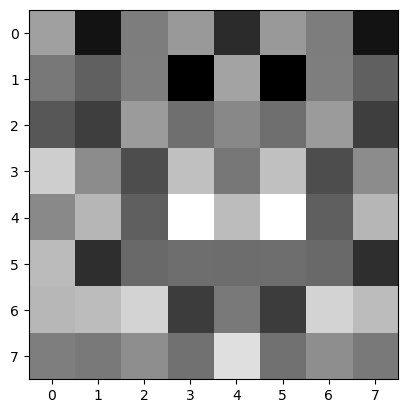

[[ 4.17370743e+00  3.78318242e+00  1.32285000e+01  1.07190042e+01
   1.08987449e+01 -1.26742133e+01  2.58474780e+00 -6.12123837e+00]
 [-1.92759824e+01 -2.06252851e+00  6.95491060e-01  1.99216981e-02
  -3.87096763e+00 -6.78951610e+00 -5.22119236e+00  8.63265563e+00]
 [ 1.78937296e+00 -5.60229100e+00 -1.03511143e+01 -5.16840003e+00
  -5.66250335e+00 -1.21284504e+01  3.33038183e+00  4.90298601e+00]
 [-1.20466199e+01 -2.31803571e+00 -7.74090862e+00  2.43415964e+00
   1.10666458e+01  4.08812226e+00 -1.30546953e+01 -7.21682078e+00]
 [ 3.30372916e+00 -9.04271175e+00 -1.60482895e+01 -1.78431258e+00
   7.25755965e+00  6.76001327e+00  2.18974751e-01  4.08730489e+00]
 [-8.90630746e+00 -6.75695129e+00 -8.53231273e+00  1.26381506e+01
  -6.73831805e+00 -1.44979176e+01 -7.43467619e+00 -3.16839919e+00]
 [ 4.86754946e+00  4.08600126e+00 -3.95234161e+00  1.60802751e+00
  -1.94367906e+00  9.74027623e+00 -6.86856923e+00 -1.15147344e+01]
 [ 1.19619565e+00  1.02995977e-02  6.40944364e-01 -5.64809275e+00
   

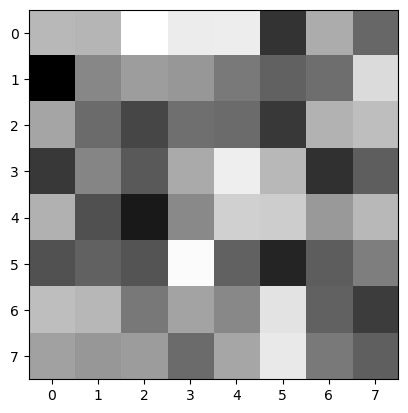

[[-1.45796792e+01 -2.16044702e+00 -1.39797241e+01 -1.64177991e+00
   1.03566674e+01 -1.96173797e+00 -5.75156427e+00 -5.40156439e+00]
 [ 6.19810872e+00  2.34276343e+00  4.36944826e+00 -1.91987682e+01
  -3.88714562e-01 -6.36676366e+00 -8.24241699e+00  8.83601900e+00]
 [ 9.73905023e+00  1.05863099e+01 -3.16048698e+00 -4.48947293e+00
  -1.00287405e+01  2.70876241e+00  1.62087618e-01  1.25725882e+00]
 [ 3.26088395e+00 -7.85654886e-03 -6.98422859e+00 -1.22627181e+01
   8.77691197e+00  5.35952929e+00 -4.23126821e+00  6.08811856e-01]
 [ 1.35724928e+01 -7.23738707e+00 -5.56555755e+00  1.42669292e+01
  -5.20277071e+00 -6.91853685e+00  1.48388165e+00  6.09130166e+00]
 [ 1.19483046e+01  7.26752723e+00 -1.31677087e+01  6.20682523e+00
  -3.61102402e+00  1.13160950e+00 -3.43293544e+00 -5.94694041e-01]
 [ 1.33950966e+00  8.09894547e+00 -8.11919556e+00 -7.51801700e+00
   4.00675948e+00  7.07967493e+00 -6.80003540e+00  5.31992256e+00]
 [ 8.48123419e+00  2.04743421e+00  1.35104579e+01  7.23574391e+00
   

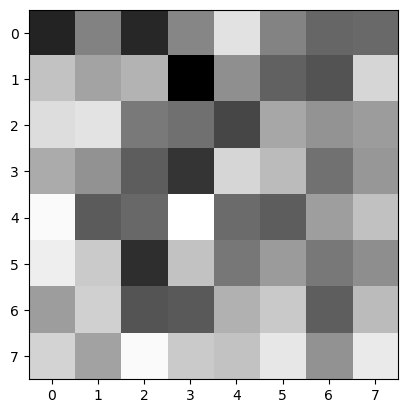

In [103]:
group = a[0]
print(group[0][15])
plt.imshow(group[0][15],cmap='gray')
plt.show()

#plot_patches(group[0])
transformed = np.array([apply_2d_transform(patch, use_dct=True) for patch in group[0]]) #t2d
#transformed.shape
#group_3d, weight = ht_filtering_hadamard(transformed, sigma, lambdaHard3d, True)

#print(transformed[15])
#plt.imshow(transformed[15],cmap='gray')
#plt.show()
#plot_patches(transformed)

#transformed3d=[]
for i in range(transformed.shape[-2]):
    for j in range(transformed.shape[-1]):
        transformed[:, i, j] = apply_1d_transform(transformed[:, i, j]) #t1d
#transformed3d=np.array(transformed3d)

#print(transformed[15])
#plt.imshow(transformed[15], cmap='gray')
#plt.show()
#plot_patches(transformed)

threshold = lambdaHard3d * sigma
after = hard_thresholding(transformed, threshold)
#after = transformed
#print(after[15])
#plt.imshow(after[15], cmap='gray')
#plt.show()
#plot_patches(after)

for i in range(after.shape[-2]):
    for j in range(after.shape[-1]):
        after[:, i, j] = reverse_1d_transform(after[:, i, j]) #t1d

print(after[15])
plt.imshow(after[15], cmap='gray')
plt.show()

final = np.array([reverse_2d_transform(patch, use_dct=True) for patch in after]) #t2d


print(final[15])
plt.imshow(final[15], cmap='gray')
plt.show()

In [ ]:
#def collab_filtering_aggregation():

for group3d, coords in a:
    
    #3D TRANSFORM
    transformed = np.array([apply_2d_transform(patch, use_dct=True) for patch in group3d]) #t2d
    for i in range(transformed.shape[-2]):
        for j in range(transformed.shape[-1]):
            transformed[:, i, j] = apply_1d_transform(transformed[:, i, j]) #t1d

    #THRESHOLD
    threshold = lambdaHard3d * sigma
    thresholded = hard_thresholding(transformed, threshold)

    ## calculate weights
    weight = 1

    #3D REVERSE
    for i in range(thresholded.shape[-2]):
        for j in range(thresholded.shape[-1]):
            thresholded[:, i, j] = reverse_1d_transform(thresholded[:, i, j]) #t1d
    
    filtered = np.array([reverse_2d_transform(patch, use_dct=True) for patch in thresholded]) #t2d

    ## AGGREGATION BUFFERS UPDATE
    x, y = coords
    patchH, patchW = filtered[0].shape
    for patch in filtered:
        nu[x:x+patchH, y:y+patchW] += weight * patch
        delta[x:x+patchH, y:y+patchW] += weight

    

In [83]:
def apply_1d_transform(array, use_dct=False):
    #if use_dct:
     #   return cv2.dct(array)  # 2D DCT
    #else:
    return fwht(array)

def reverse_1d_transform(array, use_dct=False):
    #if use_dct:
     #   return cv2.dct(array)  # 2D DCT
    #else:
    return ifwht(array)

In [82]:
#fast walsh-hadamard function
def fwht(x):
    h = 1
    while h < len(x):
        for i in range(0, len(x), h * 2):
            for j in range(h):
                x[i + j], x[i + j + h] = x[i + j] + x[i + j + h], x[i + j] - x[i + j + h]
        h *= 2
    return x

def ifwht(x):
    n = len(x)
    x = fwht(x)
    return x / n

#from sympy import fwht

In [102]:
def apply_2d_transform(patch, use_dct=False):
    if use_dct:
        return cv2.dct(patch)  # 2D DCT
    else:
        coeffs = pywt.wavedec2(patch, wavelet='bior1.5', level=2, mode='periodic')
        return coeffs

def reverse_2d_transform(patch, use_dct=False):
    if use_dct:
        return cv2.dct(patch, flags=cv2.DCT_INVERSE)
    else:
        coeffs = pywt.waverec2(patch, wavelet='bior1.5', level=2, mode='periodic')
        return coeffs

### Aggregation

## The Second Denoising Step

### Grouping

### Collaborative Filtering


### Aggregation

## Results

### PSNR: Peak Signal to Noise Ratio

In [25]:
def bm3d_1st_step(image, sigma, kHard, nHard, lambdaHard2d, lambdaHard3d, tauHard, NHard):
    height, width = image.shape

    # pad image and iterate through original frame
    window_size = nHard
    offset = window_size // 2
    padded_image = np.pad(image, offset, mode='reflect')
      
    all_groups = []
    all_coords = []

    nu = np.zeros(padded_image.shape)
    delta = np.zeros(padded_image.shape)

    X, Y = np.meshgrid(np.arange(kHard), np.arange(kHard), indexing='ij')
    
    # iterate through patches in the image with a step
    for x in range(offset, offset + height - kHard + 1, pHard):
        for y in range(offset , offset + width - kHard + 1, pHard):

            # GROUPING
            patch = padded_image[x:x+kHard, y:y+kHard]
            search_window, x_win, y_win = get_search_window(padded_image, x, y, patch_size=kHard, window_size=nHard)

            group3d, coords = build_3d_group(x_win, y_win, patch, search_window, sigma, lambdaHard2d, tauHard, NHard)
            if len(coords) < 1:
                continue

            # COLLABORATIVE FILTERING
            # 3d transform
            transformed = np.array([apply_2d_transform(patch, use_dct=True) for patch in group3d]) #t2d
            for i in range(transformed.shape[-2]):
                for j in range(transformed.shape[-1]):
                    transformed[:, i, j] = apply_1d_transform(transformed[:, i, j]) #t1d

            # thresholding
            threshold = lambdaHard3d * sigma
            thresholded = hard_thresholding(transformed, threshold)

            # calculate weights
            NPHard = np.count_nonzero(thresholded)
            weight = 1/NPHard if NPHard >= 1 else 1
            weight = np.array([weight])

            # 3d reverse
            for i in range(thresholded.shape[-2]):
                for j in range(thresholded.shape[-1]):
                    thresholded[:, i, j] = reverse_1d_transform(thresholded[:, i, j]) #t1d
            
            filtered = np.array([reverse_2d_transform(patch, use_dct=True) for patch in thresholded]) #t2d

            # AGGREGATION 
            nu, delta = update_aggregation_buffers(nu, delta, filtered, coords, weight, X, Y)

    ## BASIC ESTIMATE
    basic = np.divide(nu, delta)

    return basic